In [1]:
%matplotlib inline
%load_ext folium_magic

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import math

plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#ffffff'
plt.rcParams['axes.facecolor'] = '#ffffff'
plt.rcParams['axes.edgecolor'] = '#000000'
plt.rcParams["savefig.facecolor"] = '#ffffff'
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False

## Border Influx Predictor

### Motivation 

As most of you may agree, for an efficient control over the movement of vehicles and people crossing borders, federal agencies need to estimate the amount of traffic on a particular day. Lack of sufficient safeguards can have detrimental effects on trading between the neighboring countries. To better predict the expected number of passengers and vehicles on a given day, I am proposing an application called Border Influx Predictor (BIP). To achieve this, I will use a huge database of border crossings over the last 22 years between Mexican and Canadian borders.

### The data

The data is obtained from US Department of Transportation - Bureau of Transportation Statistics (BTS). Data provides summary statistics for inbound crossings at the U.S.-Canadian and the U.S.-Mexican border at the port level. Data are available for trucks, trains, containers, buses, personal vehicles, passengers, and pedestrians. Border crossing data are collected at border ports by U.S. Customs and Border Protection. 

The data is for two border crossings - (a) US-Canada and (b)US-Mexico. Each border has different port of entries (land). US-Mexico border share 4 US states harbouring 26 entry-ports whereas 10 adjoining states with 91 entry-ports. In last 22 years begining from January 1996, I found that approximately 75% of the total US visitors entered from Mexico while remianing 25% had entered from Canada. Out of 22 years, the maximum number of passengers entered US in the year of 1997-98 from both Mexican and Canadian borders.



In [2]:
## Load Data
data = pd.read_csv('../../data/Border_Crossing_Entry_Data.csv')

## Format Date and Time
formt = '%m/%d/%Y %I:%M:%S %p'
data['Date'] = data['Date'].apply(lambda x: datetime.strptime(x, formt))
data['Year'] = data['Date'].apply(lambda x: x.strftime('%Y'))
data['Month'] = data['Date'].apply(lambda x: x.strftime('%B'))
data['MonthNumber'] = data['Date'].apply(lambda x: x.strftime('%m'))

totalMonths = np.shape(data['Date'].unique())[0]
totalYears = totalMonths/12
minYear = np.min(data['Year'].astype(int))
maxYear = np.max(data['Year'].astype(int))
print "Data is for last %d years starting January %d to December %d"%(totalYears, minYear, maxYear)

Data is for last 22 years starting January 1996 to December 2017


In [3]:
## Clean data, filter relevant columns and rearange
temp = data['Location'].str.split('\n',1).tolist()
tempDF = pd.DataFrame(temp, columns=['State', 'Coordinates'])
data.drop(['Date', 'Location', 'Port Code'], axis=1, inplace=True)
data = pd.concat([data, tempDF], axis=1)
data['Object'] = np.where(data['Measure'].str.contains('Passengers|Pedestrians'), 'Passenger', 'Vehicle')
print "Data Shape : ", data.shape
data['Count'] = 1

## Create a pandas heirarchical index
data.sort_values(by=['Border', 'State', 'Port Name', 'Year', 'MonthNumber', 'Month', 'Object', 'Measure'], inplace=True)
data.set_index(['Border', 'State', 'Port Name', 'Year', 'MonthNumber', 'Month', 'Object', 'Measure'], inplace=True)
data.head(10)

Data Shape :  (334803, 11)


State Abbreviation  \
Border           State  Port Name Year MonthNumber Month   Object    Measure                                          
US-Canada Border ALASKA Alcan     1996 01          January Passenger Bus Passengers                              AK   
                                                                     Pedestrians                                 AK   
                                                                     Personal Vehicle Passengers                 AK   
                                                                     Train Passengers                            AK   
                                                           Vehicle   Buses                                       AK   
                                                                     Personal Vehicles                           AK   
                                                                     Rail Containers Empty                       AK   
                                                                     Rail Containers Full                        AK   
                                                                     Trains                                      AK   
                                                                     Truck Containers Empty                      AK   

                                                                                                  Value  \
Border           State  Port Name Year MonthNumber Month   Object    Measure                              
US-Canada Border ALASKA Alcan     1996 01          January Passenger Bus Passengers                   9   
                                                                     Pedestrians                      0   
                                                                     Personal Vehicle Passengers   2011   
                                                                     Train Passengers                 0   
                                                           Vehicle   Buses                            3   
                                                                     Personal Vehicles              965   
                                                                     Rail Containers Empty            0   
                                                                     Rail Containers Full             0   
                                                                     Trains                           0   
                                                                     Truck Containers Empty           0   

                                                                                                      Coordinates  \
Border           State  Port Name Year MonthNumber Month   Object    Measure                                        
US-Canada Border ALASKA Alcan     1996 01          January Passenger Bus Passengers               (62.61, -141.0)   
                                                                     Pedestrians                  (62.61, -141.0)   
                                                                     Personal Vehicle Passengers  (62.61, -141.0)   
                                                                     Train Passengers             (62.61, -141.0)   
                                                           Vehicle   Buses                        (62.61, -141.0)   
                                                                     Personal Vehicles            (62.61, -141.0)   
                                                                     Rail Containers Empty        (62.61, -141.0)   
                                                                     Rail Containers Full         (62.61, -141.0)   
                                                                     Trains                       (62.61, -141.0)   
                                                                     Truck Containers Empty     

In [4]:
## Name and Number of All Border Countries
borderCountries = data.groupby(level='Border')
nameBorderCountries = borderCountries.groups.keys()
numberBorderCountries = len(nameBorderCountries)

print 'Total Number of Border Countries - ', numberBorderCountries
print 'Name of Border Countries - ', nameBorderCountries

Total Number of Border Countries -  2
Name of Border Countries -  ['US-Mexico Border', 'US-Canada Border']


In [5]:
## Name and Numbr of All Border States
states = data.groupby(level=['State'])
nameBorderStates = states.groups.keys()
numberBorderStates = len(nameBorderStates)

print 'Total Number of Border States - ', numberBorderStates
print 'Name of Border States - ', nameBorderStates

Total Number of Border States -  14
Name of Border States -  ['VERMONT', 'ARIZONA', 'NORTH DAKOTA', 'MONTANA', 'MICHIGAN', 'WASHINGTON', 'ALASKA', 'MINNESOTA', 'NEW YORK', 'CALIFORNIA', 'NEW MEXICO', 'IDAHO', 'MAINE', 'TEXAS']


In [6]:
## Divide data based on country borders

## Mexico Border States
mexicoBorderStates = borderCountries.get_group(nameBorderCountries[0]).groupby(level='State')
namesMexicoBorderStates = mexicoBorderStates.groups.keys()
numberMexicoBorderStates = len(namesMexicoBorderStates)
print 'Number of US-Mexico Border States - ', numberMexicoBorderStates
print 'Names of US-Mexico Border States - ', namesMexicoBorderStates

# ## Canada Border States
canadaBorderStates = borderCountries.get_group(nameBorderCountries[1]).groupby(level='State')
namesCanadaBorderStates = canadaBorderStates.groups.keys()
numberCanadaBorderStates = len(namesCanadaBorderStates)
print 'Number of US-Canada Border States - ', numberCanadaBorderStates
print 'Names of US-Canada Border States - ', namesCanadaBorderStates

Number of US-Mexico Border States -  4
Names of US-Mexico Border States -  ['ARIZONA', 'CALIFORNIA', 'NEW MEXICO', 'TEXAS']
Number of US-Canada Border States -  10
Names of US-Canada Border States -  ['VERMONT', 'NORTH DAKOTA', 'MICHIGAN', 'WASHINGTON', 'ALASKA', 'MINNESOTA', 'MONTANA', 'NEW YORK', 'MAINE', 'IDAHO']


In [7]:
## Ports Each Border

## Ports US-Mexico Border
mexicoBorderStatesByPortName = borderCountries.get_group(nameBorderCountries[0]).groupby(level='Port Name')
namePortsMexicoBorders = mexicoBorderStatesByPortName.groups.keys()
numberPortsMexicoBorders = len(namePortsMexicoBorders)
print 'Number of US-Mexico Border Ports of Entry - ', numberPortsMexicoBorders
print 'Names of US-Mexico Border Ports of Entry - ', namePortsMexicoBorders

## Ports US-Mexico Border
canadaBorderStatesByPortName = borderCountries.get_group(nameBorderCountries[1]).groupby(level='Port Name')
namePortsCanadaBorders = canadaBorderStatesByPortName.groups.keys()
numberPortsCanadaBorders = len(namePortsCanadaBorders)
print 'Number of US-Canada Border Ports of Entry - ', numberPortsCanadaBorders
print 'Names of US-Canada Border Ports of Entry - ', namePortsCanadaBorders

Number of US-Mexico Border Ports of Entry -  26
Names of US-Mexico Border Ports of Entry -  ['Progreso', 'Boquillas', 'San Ysidro', 'Douglas', 'Lukeville', 'San Luis', 'Tecate', 'Laredo', 'Rio Grande City', 'Columbus', 'El Paso', 'Del Rio', 'Eagle Pass', 'Tornillo-Fabens', 'Calexico', 'Nogales', 'Sasabe', 'Roma', 'Calexico East', 'Santa Teresa', 'Brownsville', 'Presidio', 'Naco', 'Otay Mesa', 'Hidalgo', 'Andrade']
Number of US-Canada Border Ports of Entry -  91
Names of US-Canada Border Ports of Entry -  ['Porthill', 'Ogdensburg', 'Baudette', 'Frontier', 'Scobey', 'Sweetgrass', 'Grand Portage', 'Champlain-Rouses Point', 'Antler', 'Anacortes', 'Walhalla', 'Ketchikan', 'Neche', 'Alcan', 'Bar Harbor', 'St. John', 'Pinecreek', 'Fort Fairfield', 'Alexandria Bay', 'Noonan', 'Madawaska', 'International Falls-Ranier', 'Ferry', 'Sherwood', 'Whitlash', 'Nighthawk', 'Hansboro', 'Bridgewater', 'Calais', 'Friday Harbor', 'Massena', 'Norton', 'Sarles', 'Highgate Springs-Alburg', 'Wildhorse', 'Sault 

### Number of Mexican Inbound Vehicles and Passengers is more than that from Canada

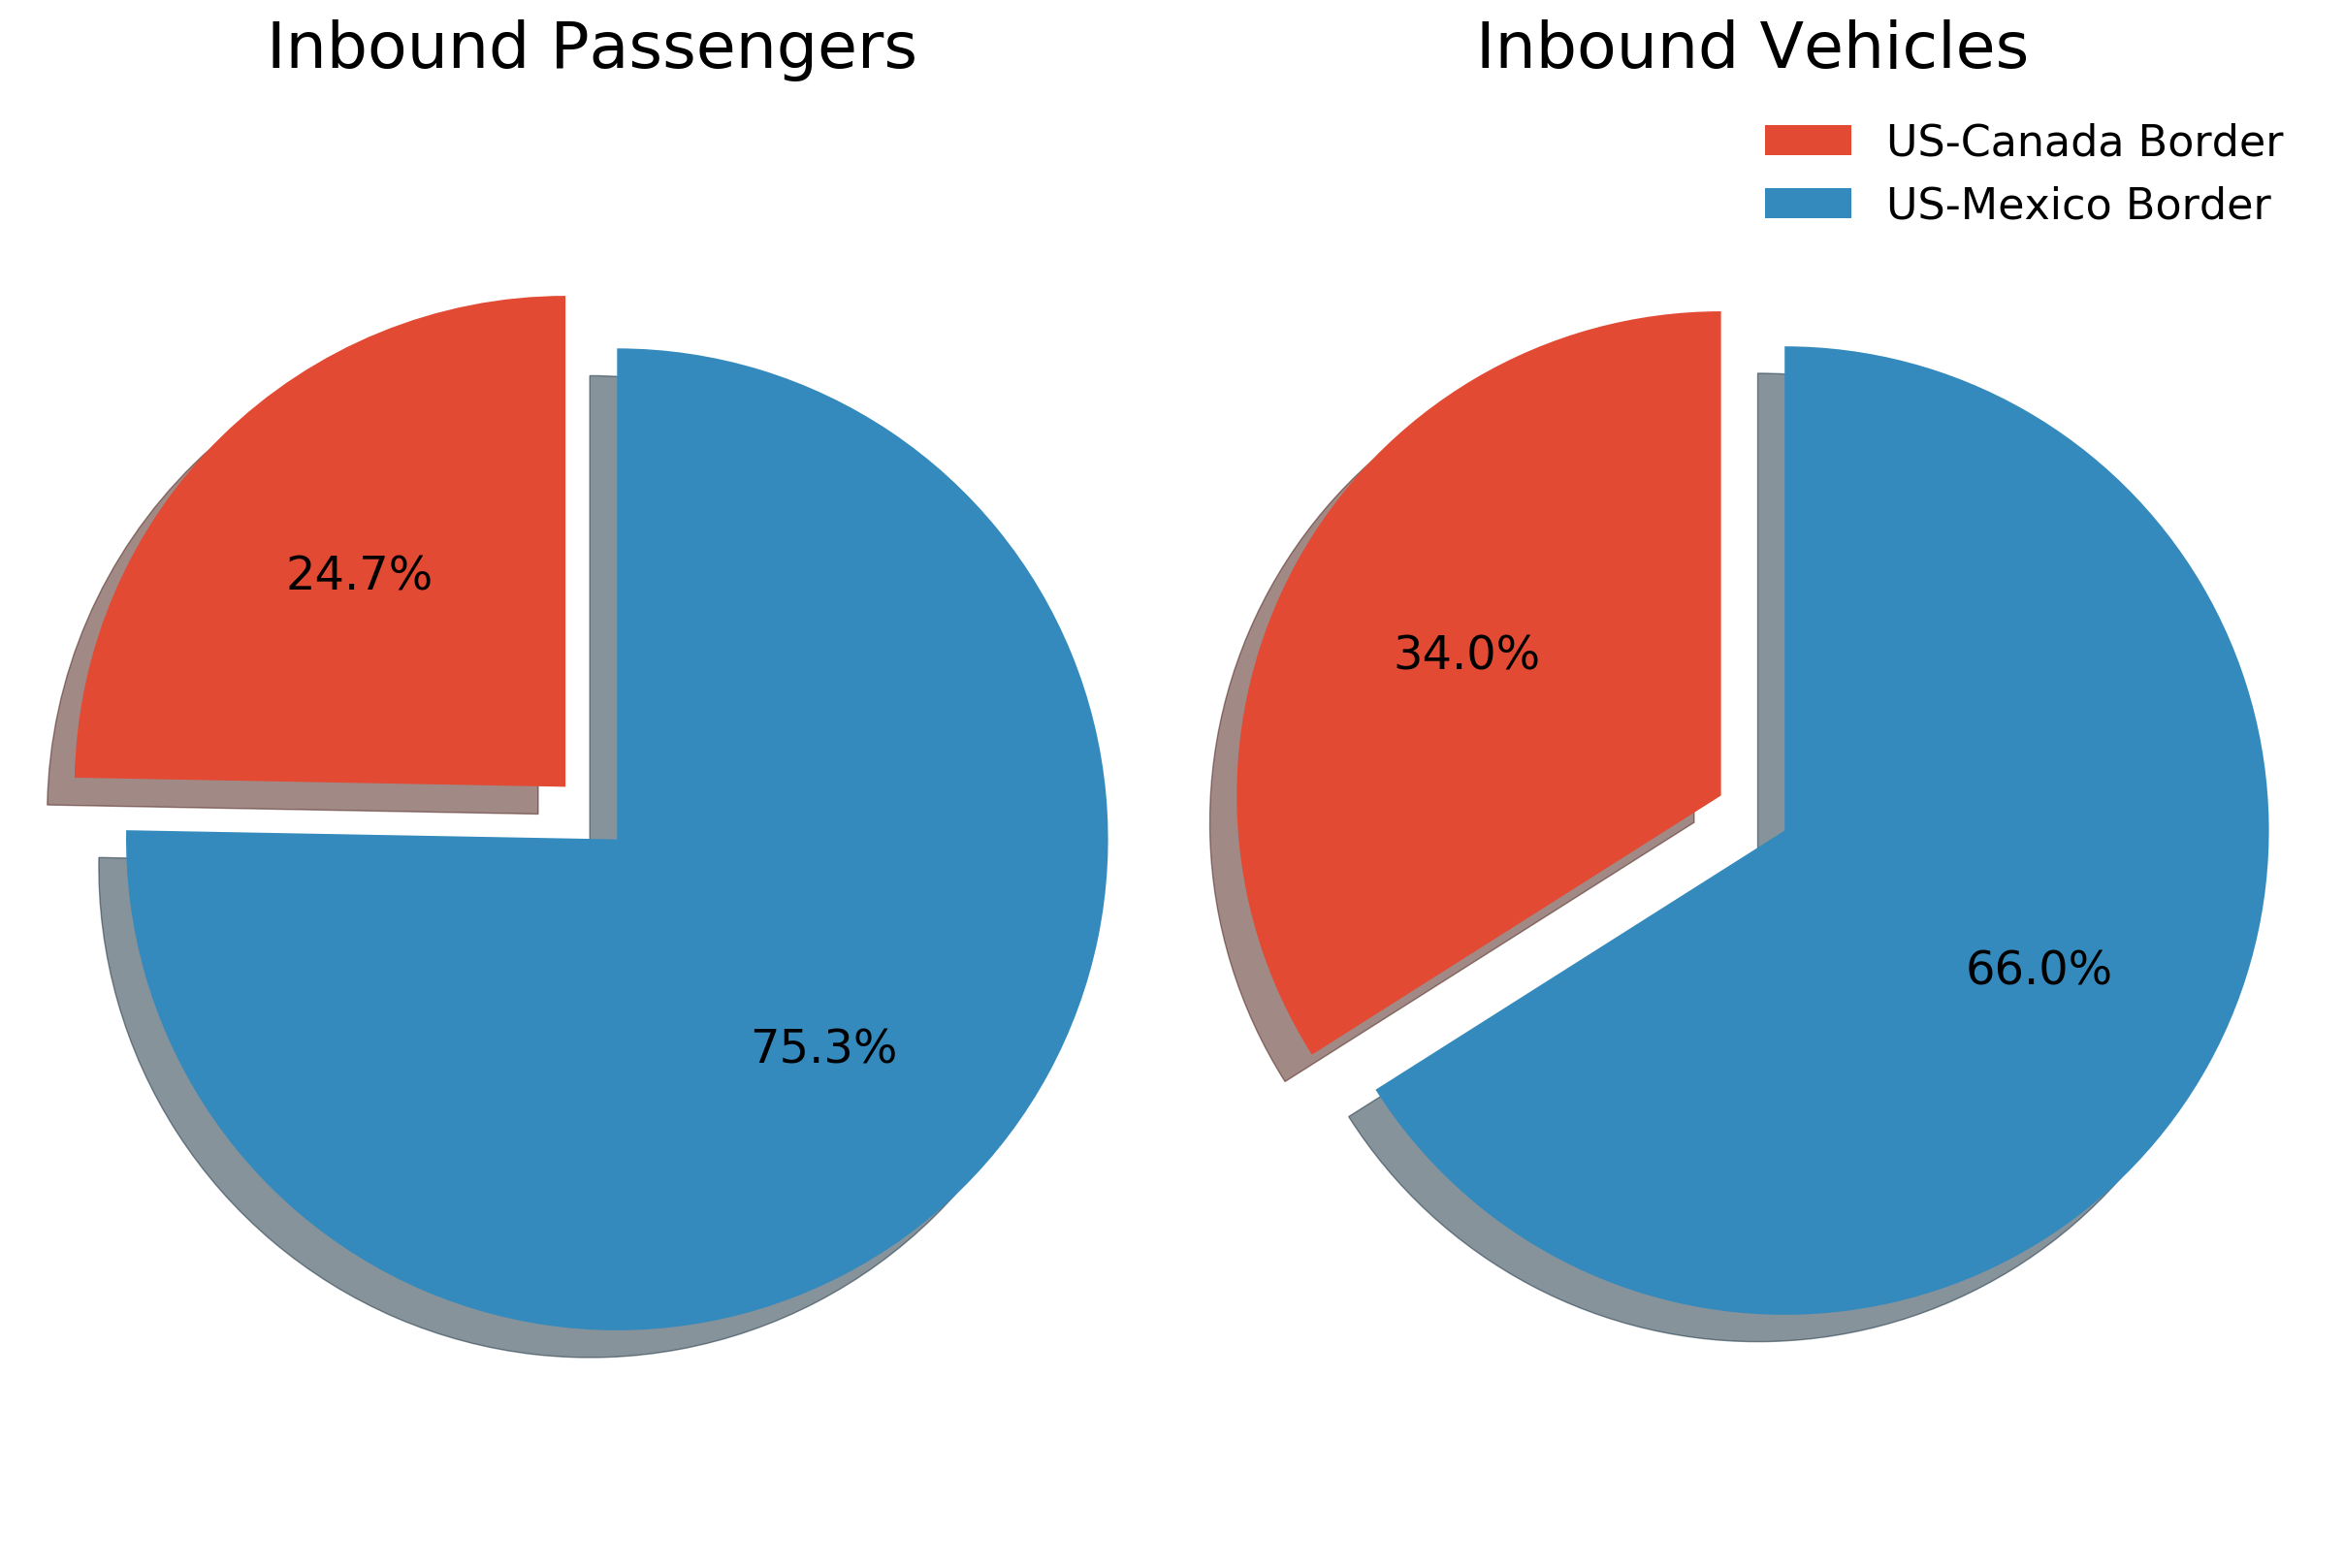

In [8]:
## Count Number of Passngers and Vehicles
inboundAllYearsByBorder = data.groupby(['Border', 'Object']).sum()
totalInbounds = data.groupby(['Object']).sum()

## Pie Chart of Percentage Passengers - All 22 Years
percentInboundAllYearsByBorder = (inboundAllYearsByBorder/totalInbounds)*100
passengers = [percentInboundAllYearsByBorder.loc['US-Canada Border', 'Passenger']['Value'], 
              percentInboundAllYearsByBorder.loc['US-Mexico Border', 'Passenger']['Value']]

vehicles = [percentInboundAllYearsByBorder.loc['US-Canada Border', 'Vehicle']['Value'], 
              percentInboundAllYearsByBorder.loc['US-Mexico Border', 'Vehicle']['Value']]


# Pie chart
labels = 'US-Canada Border', 'US-Mexico Border'
f, ax = plt.subplots(1, 2, figsize=(12, 8), dpi=200, facecolor='w', edgecolor='k')
patches, texts, autotexts = ax[0].pie(passengers, explode=(0, 0.15), labels=None, autopct='%1.1f%%', shadow=True, startangle=90)
for t in autotexts:
    t.set_size('xx-large')
ax[0].set_title('Inbound Passengers', fontsize=24)
ax[0].axis('equal')

patches, texts, autotexts = ax[1].pie(vehicles, explode=(0, 0.15), labels=None, autopct='%1.1f%%', shadow=True, startangle=90)
for t in autotexts:
    t.set_size('xx-large')
ax[1].set_title('Inbound Vehicles', fontsize=24)
ax[1].axis('equal')

plt.legend(labels=labels, fontsize=16, loc='best', fancybox=False, frameon=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.show()
plt.savefig('../../figures/pieChart_PercentageTraffic.png', bbox_inches='tight')

### Mexican Trade Shows a Steady Increase

Interestingly, I observed the number of passengers that entered from Mexico declined sharply from beginning of 1998, thereby reaching a minimum by 2011 (50 percent drop). Though, I observed a steady increase till date. In contrast, the number of passengers entering from Canada has been decreasing for the last 20 years (minima at 2016 55 percent drop). Moreover, the passengers preferred travelling using their personal vehicles instead of public transport.

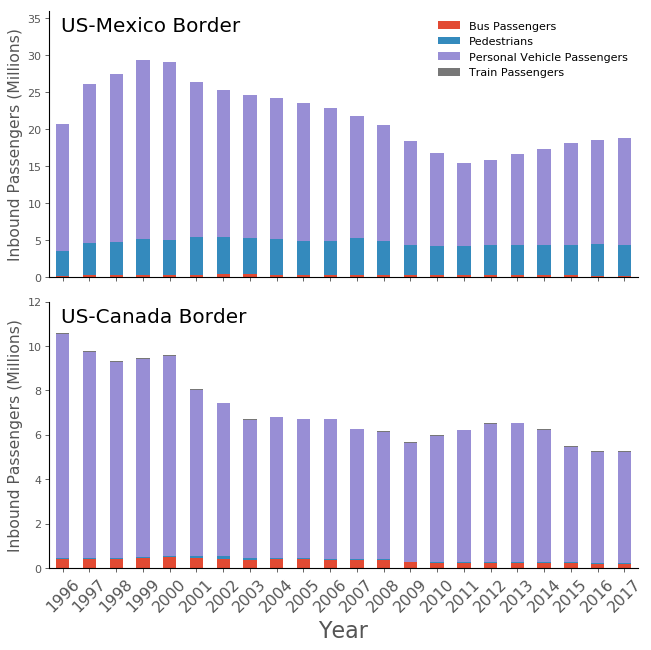

In [9]:

allYears = np.sort(data.groupby(['Year']).groups.keys())
yearWiseInboundAllStates = data.groupby(['Border', 'Year', 'Object', 'Measure'])['Value'].sum()
yearWiseInboundAllStatesPassengers = yearWiseInboundAllStates.loc['US-Mexico Border', :, 'Passenger'].unstack()/10e6

## Plot
f, ax = plt.subplots(2, 1, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
yearWiseInboundAllStatesPassengers.plot.bar(stacked=True, ax=ax[0])
ax[0].set_ylabel("Inbound Passengers (Millions)", fontsize=14)
ax[0].set_xticklabels("", fontsize=16)
ax[0].set_xlabel("", fontsize=16)
ax[0].set_ylim([0, 36])
ax[0].legend(fancybox=False, frameon=False)
ax[0].text(0.02, 0.98, 'US-Mexico Border',
        verticalalignment='top', horizontalalignment='left',
        transform=ax[0].transAxes,
        color='black', fontsize=18)

yearWiseInboundAllStatesPassengers = yearWiseInboundAllStates.loc['US-Canada Border', :, 'Passenger'].unstack()/10e6
yearWiseInboundAllStatesPassengers.plot.bar(stacked=True, legend=False, ax=ax[1])
ax[1].set_xticklabels(allYears, rotation=45, fontsize=14)
ax[1].set_xlabel("Year", fontsize=20)
ax[1].set_ylabel("Inbound Passengers (Millions)", fontsize=14)
ax[1].set_ylim([0, 12])
ax[1].text(0.02, 0.98, 'US-Canada Border',
        verticalalignment='top', horizontalalignment='left',
        transform=ax[1].transAxes,
        color='black', fontsize=18)

plt.tight_layout(pad=0.1, w_pad=0, h_pad=1)
# plt.show()
plt.savefig('../../figures/barPlot_VehicleUsedByPassengers.png', bbox_inches='tight')

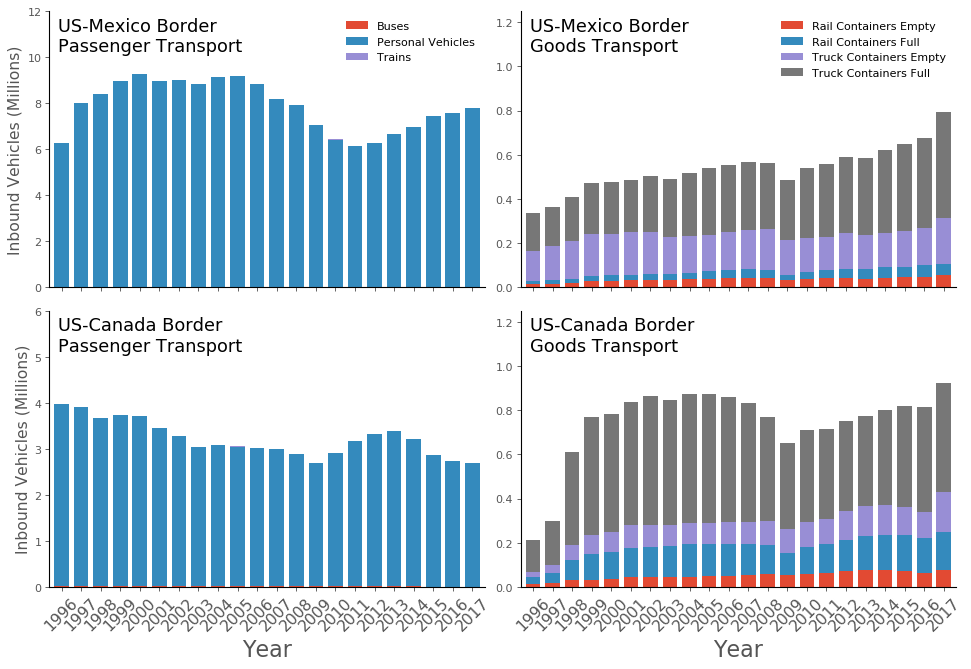

In [10]:
passenger_transport = ['Buses', 'Personal Vehicles', 'Trains']
goods_transport = ['Rail Containers Empty', 'Rail Containers Full', 'Truck Containers Empty', 'Truck Containers Full']

## Plot
f, ax = plt.subplots(2, 2, figsize=(12, 8.2), dpi=80, facecolor='w', edgecolor='k')
yearWiseInboundAllStatesVehicles = yearWiseInboundAllStates.loc['US-Mexico Border', :, 'Vehicle'].unstack()/10e6
yearWiseInboundAllStatesVehicles[passenger_transport].plot.bar(stacked=True, width=0.75, ax=ax[0,0])
ax[0,0].set_ylabel("Inbound Vehicles (Millions)", fontsize=14)
ax[0,0].set_xticklabels("", fontsize=16)
ax[0,0].set_xlabel("", fontsize=16)
ax[0,0].set_ylim([0, 12])
ax[0,0].legend(fancybox=False, frameon=False)
ax[0,0].text(0.02, 0.98, 'US-Mexico Border\nPassenger Transport',
        verticalalignment='top', horizontalalignment='left',
        transform=ax[0,0].transAxes,
        color='black', fontsize=16)

yearWiseInboundAllStatesVehicles = yearWiseInboundAllStates.loc['US-Canada Border', :, 'Vehicle'].unstack()/10e6
yearWiseInboundAllStatesVehicles[passenger_transport].plot.bar(stacked=True, legend=False, width=0.75, ax=ax[1,0])
ax[1,0].set_xticklabels(allYears, rotation=45, fontsize=14)
ax[1,0].set_xlabel("Year", fontsize=20)
ax[1,0].set_ylabel("Inbound Vehicles (Millions)", fontsize=14)
ax[1,0].set_ylim([0, 6])
ax[1,0].text(0.02, 0.98, 'US-Canada Border\nPassenger Transport',
        verticalalignment='top', horizontalalignment='left',
        transform=ax[1,0].transAxes,
        color='black', fontsize=16)

yearWiseInboundAllStatesVehicles = yearWiseInboundAllStates.loc['US-Mexico Border', :, 'Vehicle'].unstack()/10e6
yearWiseInboundAllStatesVehicles[goods_transport].plot.bar(stacked=True, width=0.75, ax=ax[0,1])
ax[0,1].set_xticklabels("", fontsize=16)
ax[0,1].set_xlabel("", fontsize=16)
ax[0,1].set_ylim([0, 1.25])
ax[0,1].legend(fancybox=False, frameon=False)
ax[0,1].text(0.02, 0.98, 'US-Mexico Border\nGoods Transport',
        verticalalignment='top', horizontalalignment='left',
        transform=ax[0,1].transAxes,
        color='black', fontsize=16)

yearWiseInboundAllStatesVehicles = yearWiseInboundAllStates.loc['US-Canada Border', :, 'Vehicle'].unstack()/10e6
yearWiseInboundAllStatesVehicles[goods_transport].plot.bar(stacked=True, legend=False, width=0.75, ax=ax[1,1])
ax[1,1].set_xticklabels(allYears, rotation=45, fontsize=14)
ax[1,1].set_xlabel("Year", fontsize=20)
ax[1,1].set_ylim([0, 1.25])
ax[1,1].text(0.02, 0.98, 'US-Canada Border\nGoods Transport',
        verticalalignment='top', horizontalalignment='left',
        transform=ax[1,1].transAxes,
        color='black', fontsize=16)


plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=1.2)
# plt.show()
plt.savefig('../../figures/barPlot_VehicleUsedForTransportation.png', bbox_inches='tight')

### Canadian Border Influx Shows Seasonal Variation

Given that either holidays or festive seasons influence human mobility, I was interested to observe if seasonal variations affect passengers visiting US from the neighbouring borders. Overall, inbound passengers from Mexico remained uniform throughout the year for the last 22 years whereas Canadian border showed a high variability. Interestingly, the Canadian borders were the most busy during summer months, indicating that holidays might affect Canadians travelling south. Surprisingly, Canadian border was least busy during the festive period (Chirstmas and New Year).

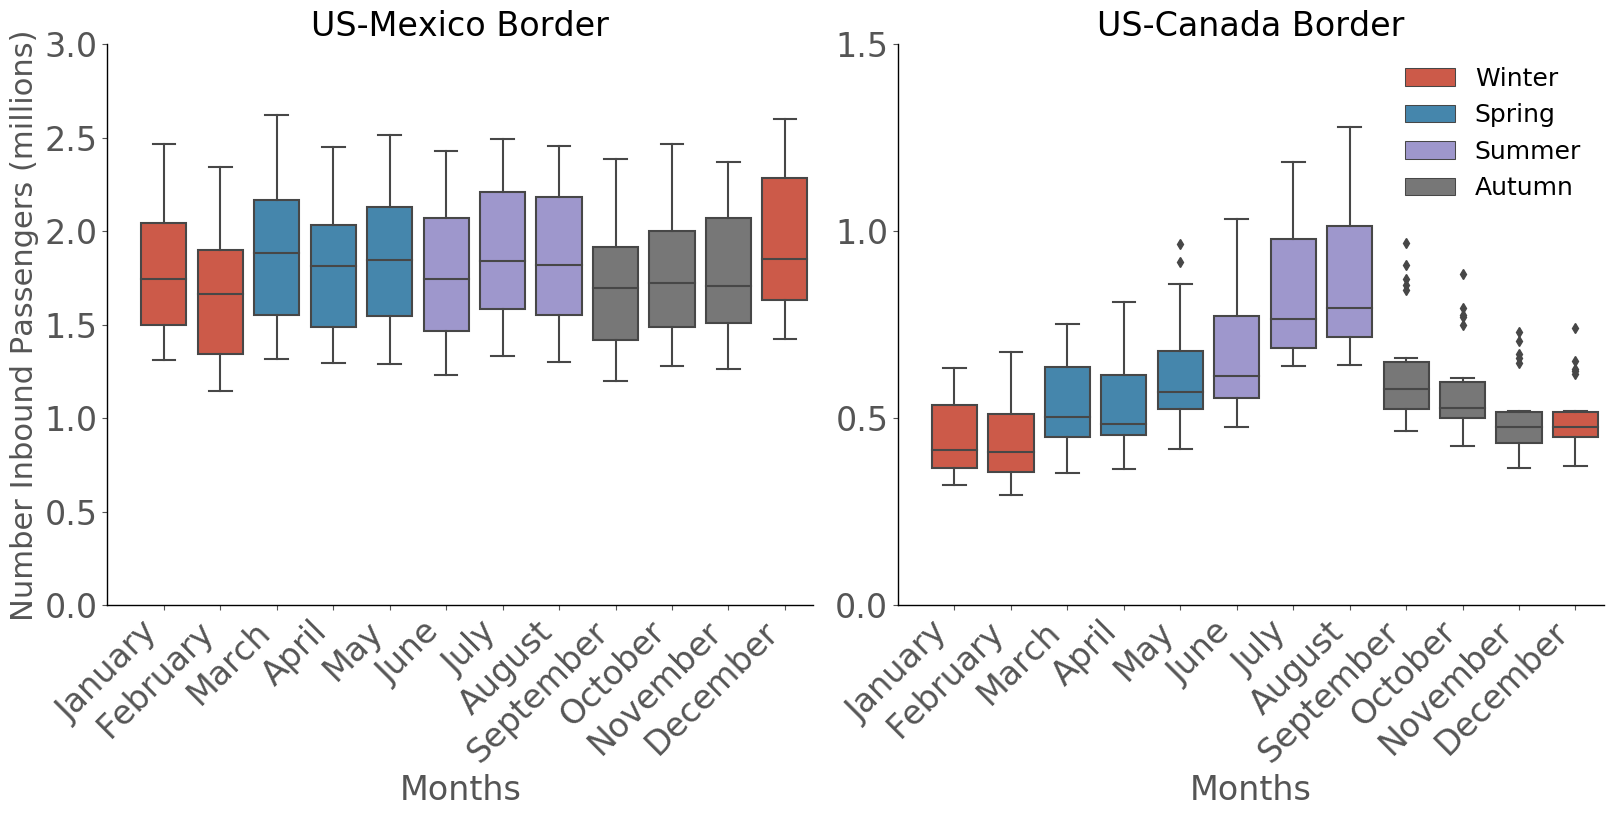

In [11]:

fourSeasons = np.array(['Winter', 'Winter', 'Spring', 'Spring',
              'Spring', 'Summer', 'Summer', 'Summer',
              'Autumn', 'Autumn', 'Autumn', 'Winter'])
sea = np.matlib.repmat(fourSeasons.T, 1, 22).squeeze().T

inboundMonths = data.groupby(['Border', 'Year', 'Month', 'MonthNumber', 'Object']).sum()
allMonths = [datetime.strptime(x, '%m').strftime('%B') for x in inboundMonths.index.levels[3].tolist()]
allMonths = [datetime.strptime(x, '%m').strftime('%B') for x in inboundMonths.index.levels[3].tolist()]

inboundMonthsMexicoMonthsPassenger = inboundMonths.loc['US-Mexico Border', :, :, :, 'Passenger']/10e6
inboundMonthsMexicoMonthsPassenger.drop('Count', axis=1, inplace=True)
inboundMonthsMexicoMonthsPassenger.sort_index(level=['Year', 'MonthNumber'], inplace=True)
inboundMonthsMexicoMonthsPassenger['seasons'] = sea
inboundMonthsMexicoMonthsPassenger.reset_index(inplace=True)
inboundMonthsMexicoMonthsPassenger.drop(['Object', 'MonthNumber', 'Border'], axis=1, inplace=True)

## Canada
inboundMonthsCanadaMonthsPassenger = inboundMonths.loc['US-Canada Border', :, :, :, 'Passenger']/10e6
inboundMonthsCanadaMonthsPassenger.drop('Count', axis=1, inplace=True)
inboundMonthsCanadaMonthsPassenger.sort_index(level=['Year', 'MonthNumber'], inplace=True)
inboundMonthsCanadaMonthsPassenger['seasons'] = sea
inboundMonthsCanadaMonthsPassenger.reset_index(inplace=True)
inboundMonthsCanadaMonthsPassenger.drop(['Object', 'MonthNumber', 'Border'], axis=1, inplace=True)

ind = np.arange(0, 13)  # the x locations for the groups

## Plot
f, ax = plt.subplots(1, 2, figsize=(16, 8), dpi=100, facecolor='w', edgecolor='k')
sns.boxplot(x="Month", y="Value", hue="seasons", data=inboundMonthsMexicoMonthsPassenger, width=0.8, dodge=False, ax = ax[0])
ax[0].set_ylabel('Number Inbound Passengers (millions)', fontsize=22)
ax[0].set_yticks(np.arange(0, 4, 0.5))
ax[0].set_yticklabels(np.arange(0, 4, 0.5), fontsize=24)
ax[0].set_xticklabels(allMonths, rotation=45, fontsize=24, ha='right')
ax[0].set_xlim([-1, 11.5])
ax[0].set_ylim([0, 3])
ax[0].set_xlabel("Months", fontsize=24)
ax[0].set_title("US-Mexico Border", fontsize=24)
ax[0].legend_.remove()

sns.boxplot(x="Month", y="Value", hue="seasons", data=inboundMonthsCanadaMonthsPassenger, width=0.8, dodge=False, ax = ax[1])
ax[1].set_xticklabels(allMonths, rotation=45, fontsize=24, ha='right')
ax[1].set_ylabel('', fontsize=18)
ax[1].set_yticks(np.arange(0, 2, 0.5))
ax[1].set_yticklabels(np.arange(0, 2, 0.5), fontsize=24)
ax[1].set_xlim([-1, 11.5])
ax[1].set_ylim([0, 1.5])
ax[1].set_xlabel("Months", fontsize=24)
ax[1].legend(fancybox=False, frameon=False, fontsize=18)
ax[1].set_title("US-Canada Border", fontsize=24)

plt.tight_layout(pad=0.1, w_pad=1, h_pad=0)
# plt.show()
plt.savefig('../../figures/boxPlot_PassengerSeosonalVariation.png', bbox_inches='tight')

In [12]:
longitudesMexico = []
latitudesMexico = []
portNamesMexico = []
data.reset_index(inplace=True)
for brd in namePortsMexicoBorders:
    tempCoord = data.loc[data['Port Name'] == brd, 'Coordinates'].unique()[0]
    longitudesMexico.append(float(tempCoord.split(',',1)[1].strip('()')))
    latitudesMexico.append(float(tempCoord.split(',',1)[0].strip('()')))
    portNamesMexico.append(brd)    
    
longitudesCanada = []
latitudesCanada = []
portNamesCanada = []
for brd in namePortsCanadaBorders:
    tempCoord = data.loc[data['Port Name'] == brd, 'Coordinates'].unique()[0]
    longitudesCanada.append(float(tempCoord.split(',',1)[1].strip('()')))
    latitudesCanada.append(float(tempCoord.split(',',1)[0].strip('()')))
    portNamesCanada.append(brd)

portWiseInboundAllYears = data.groupby(['Border', 'Port Name', 'Object']).sum()
    
portwisePassengersCanada = portWiseInboundAllYears.loc['US-Canada Border', :, 'Passenger']
portwisePassengersCanada.reset_index(inplace=True)
borderCoordinateCanada = pd.DataFrame(portNamesCanada, columns=['Port Name'])
borderCoordinateCanada['Latitudes'] = latitudesCanada
borderCoordinateCanada['Longitudes'] = longitudesCanada
borderCoordinateValueCanada = pd.merge(borderCoordinateCanada, portwisePassengersCanada, on='Port Name', how='inner')

portwisePassengersMexico = portWiseInboundAllYears.loc['US-Mexico Border', :, 'Passenger']
portwisePassengersMexico.reset_index(inplace=True)
borderCoordinateMexico = pd.DataFrame(portNamesMexico, columns=['Port Name'])
borderCoordinateMexico['Latitudes'] = latitudesMexico
borderCoordinateMexico['Longitudes'] = longitudesMexico
borderCoordinateValueMexico = pd.merge(borderCoordinateMexico, portwisePassengersMexico, on='Port Name', how='inner')

bothValues = np.hstack((borderCoordinateValueCanada['Value'], borderCoordinateValueCanada['Value']))
bothValuesMin = min(bothValues)
bothValuesMax = max(bothValues)

borderCoordinateValueCanada['Value'] = (borderCoordinateValueCanada['Value']-bothValuesMin)/(bothValuesMax-bothValuesMin)
borderCoordinateValueMexico['Value'] = (borderCoordinateValueMexico['Value']-bothValuesMin)/(bothValuesMax-bothValuesMin)

### Border Influx Hotspots

The analysis of the border crossing data also provides a crucial insight into entry-ports with the maximum traffic. These entry-ports can be considered as the hotspots for the inbound traffic and can be used further by the federal agencies to allocate resources. For instance, I observed that the El Paso, Texas and San Ysidro, California carry the maximum load of traffic between US-Mexico border. Similarly, Buffalo-Niagara Falls, New York manages maximum border influx at the US-Canada border.

In [13]:

m = folium.Map([43, -95], zoom_start=3.5)

for i in range(0, len(borderCoordinateValueMexico)):
    popup = folium.Popup(borderCoordinateValueMexico.iloc[i]['Port Name'], parse_html=False)
    folium.Circle(
      location=[borderCoordinateValueMexico.iloc[i]['Latitudes'],
                borderCoordinateValueMexico.iloc[i]['Longitudes']],
      popup=popup,
      radius=borderCoordinateValueMexico.iloc[i]['Value']*150000,
      color='crimson',
      fill=True,
      fill_color='crimson'
    ).add_to(m)

for i in range(0, len(borderCoordinateValueCanada)):
    popup = folium.Popup(borderCoordinateValueCanada.iloc[i]['Port Name'], parse_html=True)    
    folium.Circle(
      location=[borderCoordinateValueCanada.iloc[i]['Latitudes'], borderCoordinateValueCanada.iloc[i]['Longitudes']],
      popup=popup,
      radius=borderCoordinateValueCanada.iloc[i]['Value']*150000,
      color='blue',
      fill=True,
      fill_color='blue'
    ).add_to(m)
 
# Save it as html
m.save('../../figures/borderCoordinateValueMexico.html')
m

In [45]:
## Load Temperature Data
dataTemperature = pd.read_csv('../../data/temperatureInfo.txt', sep='\t', comment="%", header=None)
dataTemperature.columns = ['Station ID', 'Series Number', 'Date', 'Temperature (C)', 'Uncertainty (C)', 'Observations', 'Time of Observation']
dataTemperature.drop(['Series Number', 'Uncertainty (C)', 'Observations', 'Time of Observation'], axis=1, inplace=True)
dataTemperature['Year'] = dataTemperature['Date'].apply(lambda x: int(math.modf(x)[1]))
dataTemperature['Month'] = dataTemperature['Date'].apply(lambda x: int((math.modf(x)[0]*12.0)+0.5))
dataTemperature = dataTemperature[(dataTemperature['Year'] >= 1996) & (dataTemperature['Year'] <= 2017)]
dataTemperature.sort_values(['Year', 'Month'], inplace=True)
dataTemperature.reset_index(drop=True, inplace=True)

In [46]:
dataSite = pd.read_csv('../../data/stationIDs.txt', sep='\t', comment="%", header=None)
dataSite.columns = ['Station ID', 'Report Number', 'Station Name', 'Country', 'Record Start Date', 'Record End Date', 'Source', 'Latitude', 'Longitude', 'Elevation (m)', 'Alternative Elevation (m)', 'Lat. Uncertainty', 'Long. Uncertainty', 'Elev. Uncertainty (m)', 'Relocation Flag', 'State', 'County', 'Time Zone', 'WMO ID', 'Coop ID', 'WBAN ID', 'ICAO ID', 'USAF ID', 'NCDC ID', 'Instrument Type', 'Other IDs', 'Archive Key', 'Hash']
dataSite.drop(['Report Number', 'Station Name', 'Country', 'Record Start Date', 'Record End Date', 'Source', 'Latitude', 'Longitude', 'Elevation (m)', 'Alternative Elevation (m)', 'Lat. Uncertainty', 'Long. Uncertainty', 'Elev. Uncertainty (m)', 'Relocation Flag', 'Time Zone', 'WMO ID', 'Coop ID', 'WBAN ID', 'ICAO ID', 'USAF ID', 'NCDC ID', 'County', 'Instrument Type', 'Other IDs', 'Archive Key', 'Hash'], axis=1, inplace=True)
dataSite.reset_index(drop=True, inplace=True)

In [47]:
dataTemp = pd.merge(dataTemperature, dataSite, on='Station ID', how='inner')
dataTemp.drop(['Date'], axis=1, inplace=True)
dataTemp.replace(r'^\s*$', np.nan, regex=True, inplace = True)
dataTemp['State'] = dataTemp['State'].str.strip()
dataTemp.dropna(inplace=True)
dataTempMean = dataTemp.groupby(['State', 'Year', 'Month']).mean()

In [48]:
mexicoBorderStates = borderCountries.get_group(nameBorderCountries[0]).groupby('State Abbreviation')
mexicoBorderStatesAbbriv = mexicoBorderStates.groups.keys()
print mexicoBorderStatesAbbriv

canadaBorderStates = borderCountries.get_group(nameBorderCountries[1]).groupby('State Abbreviation')
canadaBorderStatesAbbriv = canadaBorderStates.groups.keys()
print canadaBorderStatesAbbriv

['CA', 'AZ', 'NM', 'TX']
['ME', 'WA', 'MT', 'MI', 'AK', 'MN', 'ND', 'NY', 'VT', 'ID']


In [129]:
from scipy import interpolate

## Mexico
temperatureDataMexico = dataTempMean.loc[mexicoBorderStatesAbbriv, :, :]['Temperature (C)']
temperatureDataMexico = temperatureDataMexico.unstack()
temperatureDataMexico[13] = temperatureDataMexico[1]
temperatureDataMexico_2 = temperatureDataMexico.copy()
temperatureDataMexico_2.iloc[:, :] = np.nan
temperatureDataMexico_2[3] = np.nan
temperatureDataMexico_2[6] = np.nan
temperatureDataMexico_2[9] = np.nan
temperatureDataMexico_2.columns = np.arange(1, 13)

x = temperatureDataMexico.columns.values
new_x = np.arange(1, 13)
for index, row in temperatureDataMexico.iterrows():
    f = interpolate.interp1d(x, row, fill_value='extrapolate')
    new_y = f(new_x)
    temperatureDataMexico_2.loc[(index[0], index[1]), :] = new_y
temperatureDataMexico_2.columns = allMonths
temperatureDataMexico_2 = temperatureDataMexico_2.stack().reset_index()
temperatureDataMexico_2.rename(columns={'level_2': 'Month', 0: 'Temperature'}, inplace=True)
temperatureDataMexico_2['MonthNumber'] = np.matlib.repmat(np.arange(1, 13), 1, 
                                                          22*len(mexicoBorderStatesAbbriv)).squeeze().T
temperatureDataMexico_2 = temperatureDataMexico_2.groupby(['Year', 'Month', 'MonthNumber']).mean()
temperatureDataMexico_2.sort_index(level=['Year', 'MonthNumber'], inplace=True)
temperatureDataMexico_2['seasons'] = sea
temperatureDataMexico_2.reset_index(inplace=True)


## Canada
temperatureDataCanada = dataTempMean.loc[canadaBorderStatesAbbriv, :, :]['Temperature (C)']
temperatureDataCanada = temperatureDataCanada.unstack()
temperatureDataCanada[13] = temperatureDataCanada[1]
temperatureDataCanada_2 = temperatureDataCanada.copy()
temperatureDataCanada_2.iloc[:, :] = np.nan
temperatureDataCanada_2[3] = np.nan
temperatureDataCanada_2[6] = np.nan
temperatureDataCanada_2[9] = np.nan
temperatureDataCanada_2.columns = np.arange(1, 13)
x = temperatureDataCanada.columns.values
new_x = np.arange(1, 13)
for index, row in temperatureDataCanada.iterrows():
    f = interpolate.interp1d(x, row, fill_value='extrapolate')
    new_y = f(new_x)
    temperatureDataCanada_2.loc[(index[0], index[1]), :] = new_y
temperatureDataCanada_2.columns = allMonths
temperatureDataCanada_2 = temperatureDataCanada_2.stack().reset_index()
temperatureDataCanada_2.rename(columns={'level_2': 'Month', 0: 'Temperature'}, inplace=True)
temperatureDataCanada_2['MonthNumber'] = np.matlib.repmat(np.arange(1, 13), 1, 
                                                          22*len(canadaBorderStatesAbbriv)).squeeze().T
temperatureDataCanada_2 = temperatureDataCanada_2.groupby(['Year', 'Month', 'MonthNumber']).mean()
temperatureDataCanada_2.sort_index(level=['Year', 'MonthNumber'], inplace=True)
temperatureDataCanada_2['seasons'] = sea
temperatureDataCanada_2.reset_index(inplace=True)

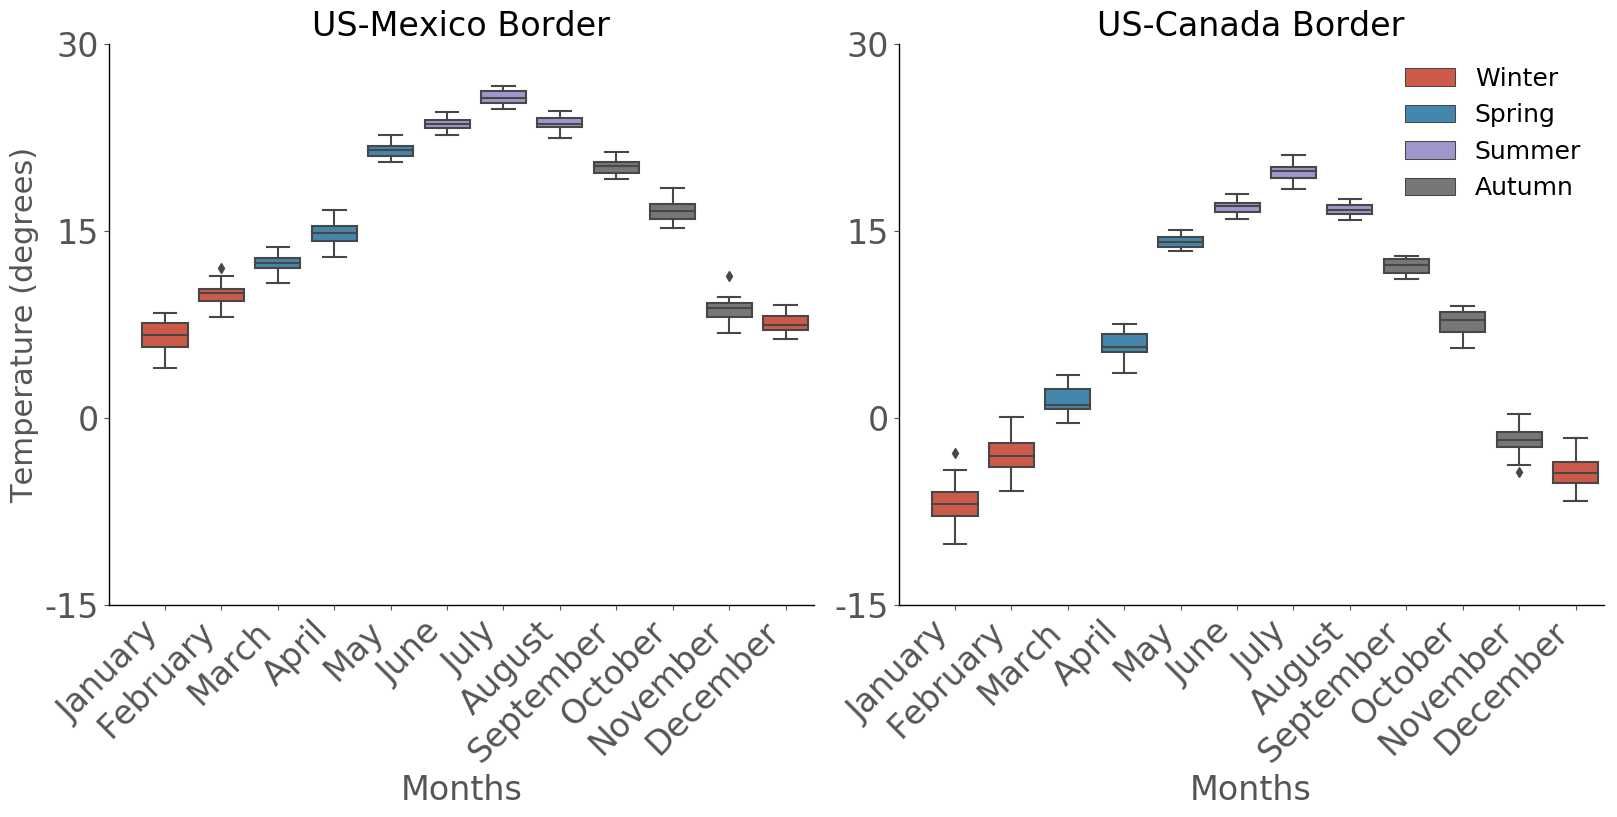

In [136]:
## Plot
f, ax = plt.subplots(1, 2, figsize=(16, 8), dpi=100, facecolor='w', edgecolor='k')
sns.boxplot(x="Month", y="Temperature", hue="seasons", data=temperatureDataMexico_2, width=0.8, dodge=False, ax = ax[0])
ax[0].set_ylabel('Temperature (degrees)', fontsize=22)
ax[0].set_yticks(np.arange(-15, 45, 15))
ax[0].set_yticklabels(np.arange(-15, 45, 15), fontsize=24)
ax[0].set_xticklabels(allMonths, rotation=45, fontsize=24, ha='right')
ax[0].set_xlim([-1, 11.5])
ax[0].set_ylim([-15, 30])
ax[0].set_xlabel("Months", fontsize=24)
ax[0].set_title("US-Mexico Border", fontsize=24)
ax[0].legend_.remove()

sns.boxplot(x="Month", y="Temperature", hue="seasons", data=temperatureDataCanada_2, width=0.8, dodge=False, ax = ax[1])
ax[1].set_xticklabels(allMonths, rotation=45, fontsize=24, ha='right')
ax[1].set_ylabel('', fontsize=18)
ax[1].set_yticks(np.arange(-15, 45, 15))
ax[1].set_yticklabels(np.arange(-15, 45, 15), fontsize=24)
ax[1].set_xlim([-1, 11.5])
ax[1].set_ylim([-15, 30])
ax[1].set_xlabel("Months", fontsize=24)
ax[1].legend(fancybox=False, frameon=False, fontsize=18)
ax[1].set_title("US-Canada Border", fontsize=24)

plt.tight_layout(pad=0.1, w_pad=1, h_pad=0)
# plt.show()
plt.savefig('../../figures/boxPlot_TemperatureSeosonalVariation.png', bbox_inches='tight')